# Resolution 2D Diffusion with a diffusion matrix (2x2) coefficient 

## Steps

- Import relevant packages: numpy and matplotlib
- Define a space and time discretization
- Define parameters needed

## Parameters of a space discretization
### X-Coordinate

* Length $L_x$ of the longitude interval (in meters)
* Step $\Delta x$ (in meters)
* Number of grid points $N_x$

The relation between the 3 parameters is: $L_x = N_x \times \Delta x$

### Y-Coordinate
* Length $L_y$ of the latitude interval (in meters)
* Step $\Delta y$ (in meters)
* Number of grid points $N_y$

The relation between the 3 parameters is: $L_y = N_y \times \Delta y$

In [1]:
import numpy as np
from scipy import ndimage as nd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline

Import useful functions from local module:

In [2]:
import DiagField_2D_Diffusion_test as uti

## Define space and time discretization

In [37]:
dx, dy, Nx, Ny, xm, ym = uti.grid_param()
sla = uti.make_sla(xm,ym)+0.04*np.random.randn(100,80)
#derivhX = uti.gradientX(sla1)
#derivhY = uti.gradientY(sla1)

# y_deri = uti.f_derivative(sla, axis=1)

### Plotting the SSH Field

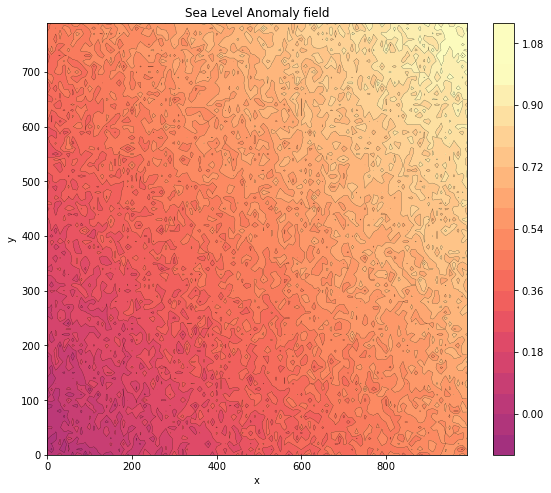

In [39]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0, 0, 0.52, 1])    # [left, bottom, width, height] 

vmin, vmax = -1, 1
ax1.contour(xm, ym, sla, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xm, ym, sla, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax1.set_title("Sea Level Anomaly field")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pc0, ax=ax1)

### Initial Smoothing Process Using Convolution Filter

## Parameters needed for computing the 2D Diffusion equation

In [32]:
Kmat = np.array([[0, 0],[0,0.5]])
#dt = 0.5 * 0.5 * (np.min(dx)**2 + np.min(dy)**2)/np.max(Kmat)   # dt < (dx^2 + dy^2)/(2 max(k))
dt = 0.1 / np.max(Kmat)
sla_d = np.copy(sla)


for it in range(200):
    derivhX = uti.gradientX(sla_d)
    derivhY = uti.gradientY(sla_d)
    kgradhX = (Kmat[0,0]*(derivhX) + Kmat[0,1]*(derivhY))
    kgradhY = (Kmat[1,0]*(derivhX) + Kmat[1,1]*(derivhY))
    divField = uti.divergence(kgradhX, kgradhY)
    sla_d = sla_d + divField * dt
    sla_d = uti.bc1(sla_d)
    # ameliorer avec une condition de continuite des isolignes ??
    #sla_d = uti.f_von_neuman_euler(sla_d)
    #sla_d = uti.bk_von_neuman_euler(sla_d)
    

In [33]:
np.shape(derivhX)

(100, 80)

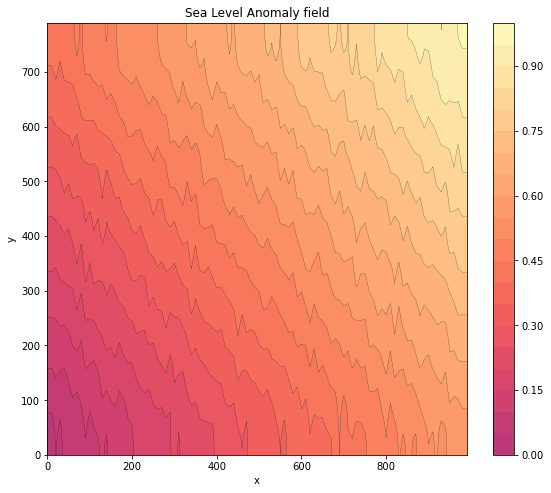

In [34]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0, 0, 0.52, 1])    # [left, bottom, width, height] 

vmin, vmax = -1, 1
ax1.contour(xm, ym, sla_d, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xm, ym, sla_d, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax1.set_title("Sea Level Anomaly field")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pc0, ax=ax1)

In [30]:
Kmat

array([[5, 7],
       [4, 3]])

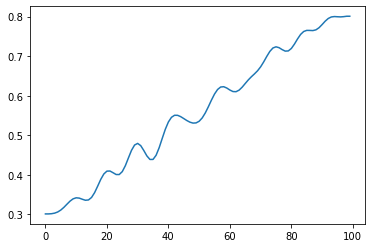

In [31]:
plt.plot(sla_d[:,50])

In [ ]:
sla_d = uti.f_von_neuman_euler(sla_d, axis=None)
sla_d[-1,50], sla_d[-2,50]

In [ ]:
a=None
if a==1 or a==None:
    print("hello")

## Initialization and storage arrays for an arbitrary function to create a 2D SSH field (x and y coordinates)

In [ ]:
# Diffusion with fixed boundaries
# first method - Looping with x and y
conc = np.copy(sla)
for it in range(Nt):
    conc_time = np.copy(conc)  # Loop the function in time
    for ix in range(1,Nx-1):
        for iy in range(1,Ny-1):
            #conc[ix,iy] = conc_time[ix,iy] + alpha * ((conc_time[ix+1,iy+1] - 2 * (conc_time[ix,iy]) + conc_time[ix-1,iy-1])/dx*dx)  # Resolution equation for 1D Diffusion
            termX = conc_time[ix+1,iy] - (2 * conc_time[ix,iy]) + conc_time[ix-1,iy]
            termX /= (dx*dx)
            termY = conc_time[ix,iy+1] - (2 * conc_time[ix,iy]) + conc_time[ix,iy-1]
            termY /= (dy*dy)
            conc[ix,iy] = conc_time[ix,iy] + alpha * (termX + termY)

In [ ]:
# Diffusion with fixed boundaries
# Second method - Using Python facilities without looping x and y
conc = np.copy(sla)
for it in range(Nt):
    conc_time = np.copy(conc)  # Loop the function in time
    termX = np.roll(conc_time, -1, axis=0) - (2 * conc_time) + np.roll(conc_time, 1, axis=0) # rolls array as a whole in x-direction
    termX /= (dx*dx)
    termY = np.roll(conc_time, -1, axis=1) - (2 * conc_time) + np.roll(conc_time, 1, axis=1) # rolls elements in array, changing y
    termY /= (dy*dy)
    conc = conc_time + alpha * (termX + termY)
    conc[0,:], conc[-1,:], conc[:,0], conc[:,-1] = conc_time[0,:], conc_time[-1,:], conc_time[:,0], conc_time[:,-1] #storing the new values as initial

## Plotting diffused sla with fixed boundaries

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0, 0, 0.52, 1])    # [left, bottom, width, height] 
ax2 = fig.add_axes([0.57, 0, 0.51, 1])

vmin, vmax = -1, 1
ax1.contour(xm, ym, sla, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xm, ym, sla, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax1.set_title("Sea Level Anomaly field")
fig.colorbar(pc0, ax=ax1)


vmin, vmax = -1, 1
ax2.contour(xm, ym, conc, 20, colors='black', linewidths = 0.2)
pc0=ax2.contourf(xm, ym, conc, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax2.set_title("Diffused Sea Level Anomaly field")
fig.colorbar(pc0, ax=ax2)

- Homogeneous diffusion (scalar) with von Neumann scheme
- No prescibed direction in diffusion (isotropic)

In [ ]:
# Diffusion with zero derivatives at the boundaries (von Neumann conditions)
conc = np.copy(sla)
for it in range(Nt):
    conc_time = np.copy(conc)  # Loop the function in time
    termX = np.roll(conc_time, -1, axis=0) - (2 * conc_time) + np.roll(conc_time, 1, axis=0) # rolls array as a whole in x-direction
    termX /= (dx*dx)
    termY = np.roll(conc_time, -1, axis=1) - (2 * conc_time) + np.roll(conc_time, 1, axis=1) # rolls elements in array, changing y
    termY /= (dy*dy)
    conc = conc_time + alpha * (termX + termY)
    conc[0,:], conc[-1,:], conc[:,0], conc[:,-1] = conc[1,:], conc[-2,:], conc[:,1], conc[:,-2] 

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_axes([0, 0, 0.52, 1])    # [left, bottom, width, height] 
ax2 = fig.add_axes([0.57, 0, 0.51, 1])

vmin, vmax = -1, 1
ax1.contour(xm, ym, sla, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xm, ym, sla, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax1.set_title("Sea Level Anomaly field")
fig.colorbar(pc0, ax=ax1)


vmin, vmax = -1, 1
ax2.contour(xm, ym, conc, 20, colors='black', linewidths = 0.2)
pc0=ax2.contourf(xm, ym, conc, 20, vmin=vmin, vmax=vmax, cmap = "magma")
ax2.set_title("Diffused Sea Level Anomaly field with Boundaries")
fig.colorbar(pc0, ax=ax2)

In [ ]:
np.arange?